In [1]:
import numpy as np
from numba import njit
import pickle
from sklearn.ensemble import BaggingClassifier
from sklearn.tree._classes import DecisionTreeClassifier
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal

from hyppo.tools import multimodal_independence, indep_sim
from hyppo.ksample._utils import k_sample_transform
from tqdm import tqdm

import sys
import os
import multiprocessing as mp
from joblib import Parallel, delayed

C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
def test_stat_helper(est_nodes, eval_nodes, est_classes, class_counts, K, kappa=3, base=2):
    """
    est_nodes : list
        Leaf indices used for voting
    eval_nodes : list
        Leaf indices in which a sample from the density subsample falls
    est_classes : list
        Voter class labels in est_node leaves
    """
    for i in range(len(est_nodes)):
        class_counts[est_nodes[i], est_classes[i]] += 1

    # Total number of estimation points in each leaf.
    row_sums = class_counts.sum(axis=1)
    row_sums[row_sums == 0] = 1  # Avoid divide by zero.
    class_probs = class_counts / row_sums[:, None]

    # Make the nodes that have no estimation indices uniform.
    # This includes non-leaf nodes, but tha t will not affect the estimate.
    class_probs[np.argwhere(class_probs.sum(axis=1) == 0)] = [1 / K]*K
    # Apply finite sample correction and renormalize.
    where_0 = np.argwhere(class_probs == 0)
    for elem in where_0:
        class_probs[elem[0], elem[1]] = 1 / \
            (kappa*class_counts.sum(axis=1)[elem[0]])
    row_sums = class_probs.sum(axis=1)
    class_probs = class_probs / row_sums[:, None]

    # Place evaluation points in their corresponding leaf node.
    # Store evaluation posterior in a num_eval-by-num_class matrix.
    eval_class_probs = class_probs[eval_nodes]
    eval_entropies = [entropy(posterior, base=base)
                      for posterior in eval_class_probs]
    return np.mean(eval_entropies)


In [3]:
def uf(X, y, n_estimators=300, max_samples=.4, base=2, kappa=3, reps=100, n_jobs=None):
    # Build forest with default parameters.
    model = BaggingClassifier(DecisionTreeClassifier(),
                              n_estimators=n_estimators,
                              max_samples=max_samples,
                              n_jobs=n_jobs,
                              bootstrap=False)
    model.fit(X, y)
    n = X.shape[0]
    K = model.n_classes_
    _, y = np.unique(y, return_inverse=True)

    cond_entropy = 0
    final_null_dist = [0] * 100

    tree_est_nodes = []
    tree_eval_nodes = []
    tree_unsampled_indices = []

    # Get real test statistics
    for tree_idx, tree in enumerate(model):
        # Find the indices of the training set used for partition.
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0, n), sampled_indices)
        np.random.shuffle(unsampled_indices)
        tree_unsampled_indices.append(unsampled_indices)

        # Randomly split the rest into voting and evaluation.
        vote_indices = unsampled_indices[:len(unsampled_indices)//2]
        eval_indices = unsampled_indices[len(unsampled_indices)//2:]

        # Store the posterior in a num_nodes-by-num_classes matrix.
        # Posteriors in non-leaf cells will be zero everywhere
        # and later changed to uniform.
        node_counts = tree.tree_.n_node_samples
        class_counts = np.zeros((len(node_counts), K))
        est_nodes = tree.apply(X[vote_indices])
        tree_est_nodes.append(est_nodes)
        eval_nodes = tree.apply(X[eval_indices])
        tree_eval_nodes.append(eval_nodes)

        cond_entropy += test_stat_helper(
            est_nodes, eval_nodes, y[vote_indices], class_counts, K)

    # Generate null dist
    for j in range(reps):
        for tree, unsampled_indices, est_nodes, eval_nodes in zip(
            model, tree_unsampled_indices, tree_est_nodes, tree_eval_nodes
        ):
            node_counts = tree.tree_.n_node_samples
            class_counts = np.zeros((len(node_counts), K))
            y_vote = y[unsampled_indices]
            np.random.shuffle(y_vote)
            final_null_dist[j] += test_stat_helper(
                est_nodes, eval_nodes, y_vote[:len(unsampled_indices)//2], class_counts, K)

    # note: shuffling y doesn't change these outputs
    new_final_null_dist = [entropy([np.mean(
        y), 1 - np.mean(y)], base=2) - val / n_estimators for val in final_null_dist]

    final_stat = entropy([np.mean(y), 1 - np.mean(y)],
                         base=2) - cond_entropy / n_estimators
    return final_stat, new_final_null_dist

In [4]:
MAX_SAMPLE_SIZE = 100
STEP_SIZE = 20
SAMP_SIZES = range(10, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
POWER_REPS = 20

SIMULATIONS = [
    # "linear": "Linear",
    # "multimodal_independence": "Independence"
    # linear,
    multimodal_independence
]

In [26]:
def estimate_power(sim, n_jobs=None):
    samp_size_dict = dict()
    samp_size_dict['sample_sizes'] = SAMP_SIZES
    samp_size_dict['n_power_reps'] = POWER_REPS
    power = []
    for n_samples in SAMP_SIZES:
        pvalues = []
        samp_size_dict[n_samples] = {'stats': [], 'null_dists': []}
        for p in tqdm(range(POWER_REPS)):
            plt.clf()
            np.random.seed(None)
            matrix1, matrix2 = multimodal_independence(n_samples, 2)
            x, y = k_sample_transform([matrix1, matrix2])
            stat, null_dist = uf(x, y.ravel(), n_jobs=n_jobs)
            samp_size_dict[n_samples]['stats'].append(stat)
            samp_size_dict[n_samples]['null_dists'].append(null_dist)
            pvalue = np.mean(np.asarray(null_dist) >= stat)
            print("P-value: " + str(pvalue))
            print(f'Test stat: {stat}')
            print(f'Null dist: {null_dist[:5]}')
            plt.hist(null_dist)
            plt.axvline(stat, c='r', ls='--')
            plt.show()
            pvalues.append(pvalue)
        plt.hist(pvalues, range=(0,1))
        plt.show()
        power.append(np.mean(np.asarray(pvalues) <= 0.05))
        #power.append((pvalues >= 0.05).sum() / POWER_REPS)

    with open('multimodal_independence_power_reps.pkl', 'wb') as handle:
        pickle.dump(samp_size_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    np.savetxt('multimodal_independence_power2.csv',
               power, delimiter=',')

    return power

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

P-value: 0.65
Test stat: 0.1560367947642085
Null dist: [0.16075291058053442, 0.149345356637269, 0.15797440525179796, 0.161306238777418, 0.17233242494310375]


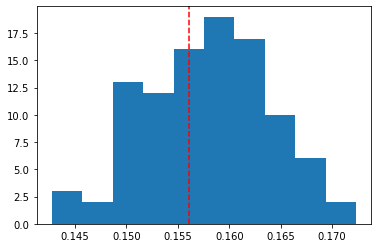

  5%|████▏                                                                              | 1/20 [00:32<10:25, 32.90s/it]

P-value: 0.81
Test stat: 0.14363983983598305
Null dist: [0.14589184678960943, 0.16388062134015824, 0.15153366160889958, 0.1374268946396171, 0.15432461688545485]


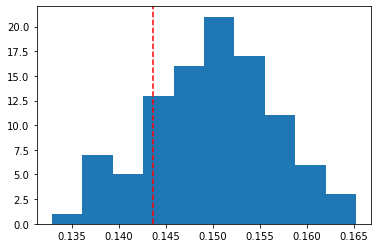

 10%|████████▎                                                                          | 2/20 [01:04<09:47, 32.64s/it]

P-value: 0.0
Test stat: 0.20060333098638294
Null dist: [0.15192065939021582, 0.15934152040689076, 0.1619618907966971, 0.14752269851682032, 0.15310052904180504]


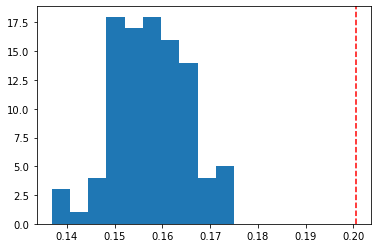

 15%|████████████▍                                                                      | 3/20 [01:36<09:11, 32.46s/it]

P-value: 0.13
Test stat: 0.15885468462678076
Null dist: [0.15674780685780776, 0.1590117547489438, 0.1609523875858816, 0.16486699463066834, 0.14941123060700456]


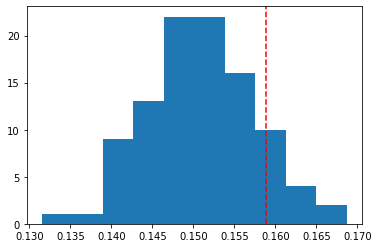

 20%|████████████████▌                                                                  | 4/20 [02:09<08:37, 32.37s/it]

P-value: 0.26
Test stat: 0.14917562309132915
Null dist: [0.14304130864590192, 0.14619379717370617, 0.14256332598857546, 0.13987263173198505, 0.14327457527815668]


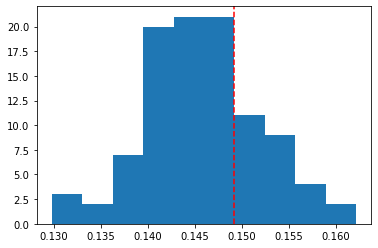

 25%|████████████████████▊                                                              | 5/20 [02:43<08:13, 32.88s/it]

P-value: 0.8
Test stat: 0.14063858675352248
Null dist: [0.16222751571248084, 0.14458097766219113, 0.14124107544565812, 0.15775596564227523, 0.1506346062567966]


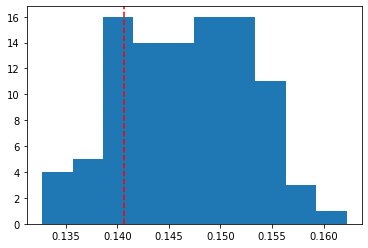

 30%|████████████████████████▉                                                          | 6/20 [03:16<07:43, 33.13s/it]

P-value: 0.83
Test stat: 0.14175479921457002
Null dist: [0.1383993622544737, 0.15217667215882535, 0.16530615660347248, 0.15548179320801714, 0.14218498906734867]


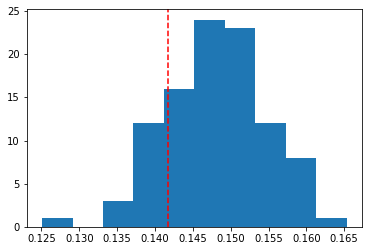

 35%|█████████████████████████████                                                      | 7/20 [03:49<07:07, 32.90s/it]

P-value: 1.0
Test stat: 0.13638827283660626
Null dist: [0.15505324721829628, 0.15222297818597486, 0.15205332346053857, 0.14719470413362445, 0.15570824187121024]


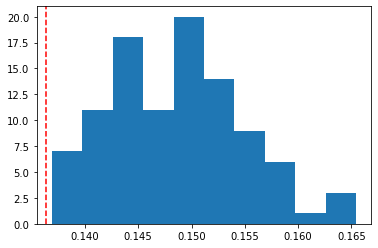

 40%|█████████████████████████████████▏                                                 | 8/20 [04:21<06:31, 32.62s/it]

P-value: 0.19
Test stat: 0.1524371997598326
Null dist: [0.14578914278372057, 0.14829866457739893, 0.15165518373758335, 0.16254962564999653, 0.14420568541206114]


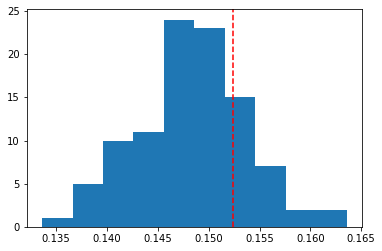

 45%|█████████████████████████████████████▎                                             | 9/20 [04:54<06:00, 32.75s/it]

P-value: 0.86
Test stat: 0.14848995833561252
Null dist: [0.1575434543725801, 0.14263710566196264, 0.15906686192422614, 0.16332764927504295, 0.152178623166892]


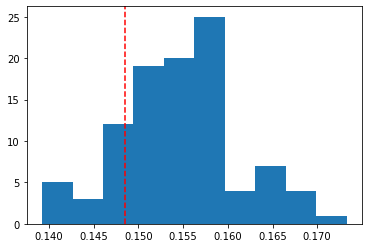

 50%|█████████████████████████████████████████                                         | 10/20 [05:26<05:24, 32.48s/it]

P-value: 0.11
Test stat: 0.15150430590661723
Null dist: [0.15013120255396484, 0.1397321263059782, 0.14260277644978636, 0.150660390892828, 0.1527261153798799]


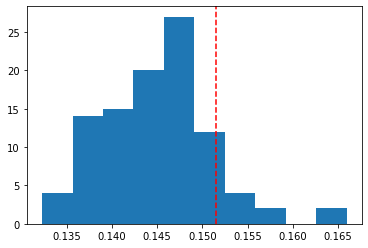

 55%|█████████████████████████████████████████████                                     | 11/20 [06:04<05:08, 34.25s/it]

P-value: 0.05
Test stat: 0.15737319086493895
Null dist: [0.14871656940984257, 0.1490062567938487, 0.1486877655559572, 0.14098479107331496, 0.1532820076369853]


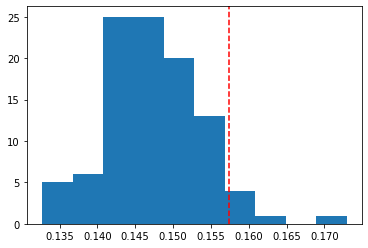

 60%|█████████████████████████████████████████████████▏                                | 12/20 [06:39<04:35, 34.40s/it]

P-value: 0.81
Test stat: 0.14781202815530725
Null dist: [0.14980589315879744, 0.15819319283965172, 0.15345138025721916, 0.14948674440942222, 0.1420777113464099]


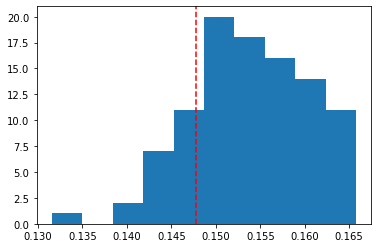

 65%|█████████████████████████████████████████████████████▎                            | 13/20 [07:11<03:56, 33.82s/it]

P-value: 0.94
Test stat: 0.13583059565388322
Null dist: [0.15037656772277597, 0.1416382971860488, 0.1459959867037749, 0.13975790637938867, 0.14797269676733937]


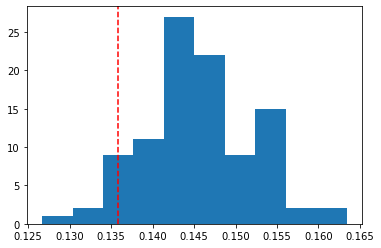

 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [07:43<03:19, 33.27s/it]

P-value: 0.0
Test stat: 0.17674007317095786
Null dist: [0.1496690097612139, 0.15044240280076393, 0.1452898227178112, 0.15589274609828752, 0.14625131654040024]


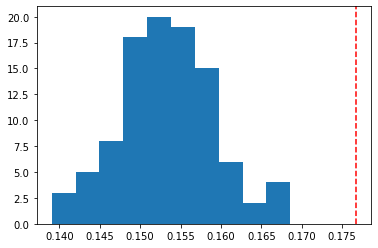

 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [08:16<02:45, 33.01s/it]

P-value: 0.4
Test stat: 0.15066863176490763
Null dist: [0.14929795312325178, 0.14453208240634186, 0.13482767401361762, 0.15679989088650936, 0.15418809660882726]


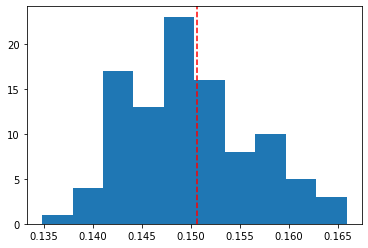

 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [08:50<02:13, 33.35s/it]

P-value: 0.45
Test stat: 0.14104973347674976
Null dist: [0.1405264192032628, 0.14722046390205346, 0.14872849129662047, 0.1424934524548015, 0.13773833981025996]


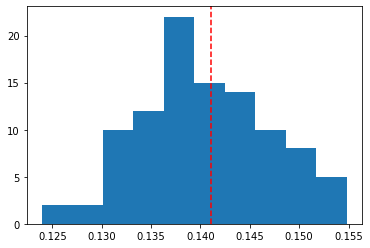

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [09:23<01:39, 33.32s/it]

P-value: 0.81
Test stat: 0.14925444305501345
Null dist: [0.16171606931099936, 0.14926904485938897, 0.15691530648310525, 0.16285366700409865, 0.14667828188272525]


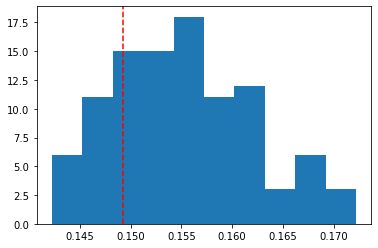

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [09:55<01:05, 32.96s/it]

P-value: 0.29
Test stat: 0.1596360874987749
Null dist: [0.14723379784603485, 0.15398598327507562, 0.16275282652728695, 0.15298316282679247, 0.1523725194768305]


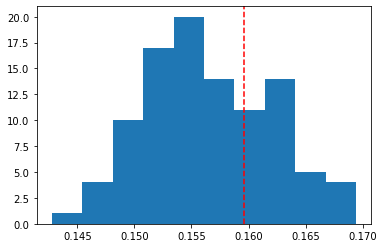

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [10:27<00:32, 32.74s/it]

P-value: 0.24
Test stat: 0.15913660872607538
Null dist: [0.15070615355542993, 0.16392659657538755, 0.16176160991119826, 0.14909585742762843, 0.15519777521840628]


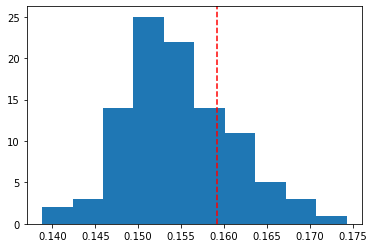

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [11:00<00:00, 33.02s/it]


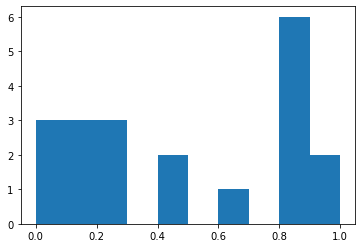

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

P-value: 0.44
Test stat: 0.14018169394340774
Null dist: [0.14314365783896943, 0.13481322441690202, 0.138718668120419, 0.13948338495715007, 0.13951238100177665]


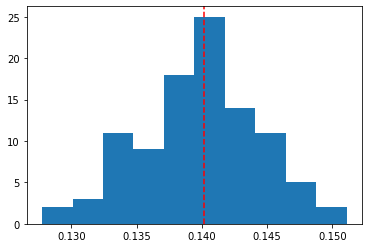

  5%|████▏                                                                              | 1/20 [00:40<12:44, 40.25s/it]

P-value: 0.47
Test stat: 0.14351579237985124
Null dist: [0.14245006172941788, 0.14335780264390796, 0.1475969411830097, 0.14141660985495907, 0.14535170560929955]


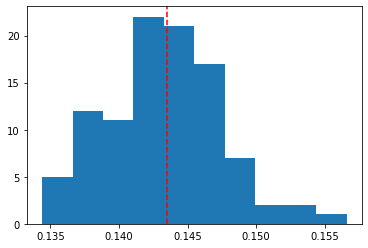

 10%|████████▎                                                                          | 2/20 [01:21<12:07, 40.43s/it]

P-value: 0.02
Test stat: 0.15026736098348747
Null dist: [0.13221800390859473, 0.13640219440958423, 0.1371437500809065, 0.14064561499717454, 0.14351269357434238]


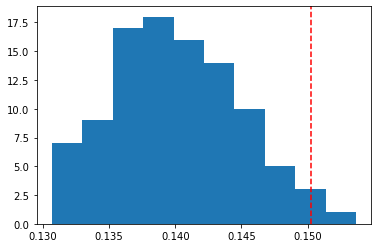

 15%|████████████▍                                                                      | 3/20 [02:00<11:24, 40.24s/it]

P-value: 0.86
Test stat: 0.13948836615390825
Null dist: [0.15175507338190097, 0.1498838922154495, 0.14686345856793037, 0.14830920064111197, 0.14171961466021377]


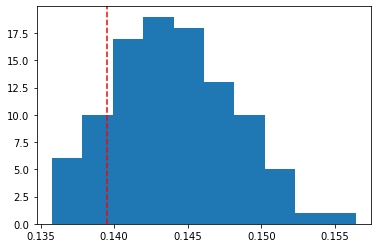

 20%|████████████████▌                                                                  | 4/20 [02:40<10:42, 40.18s/it]

P-value: 0.69
Test stat: 0.14301929642255518
Null dist: [0.14694458708321445, 0.14428101354483303, 0.14528567930130198, 0.14754373610762228, 0.1386513745690492]


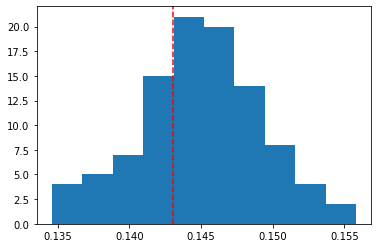

 25%|████████████████████▊                                                              | 5/20 [03:21<10:03, 40.22s/it]

P-value: 0.9
Test stat: 0.13840069784230447
Null dist: [0.148278437302107, 0.14642510274320386, 0.14140145353056355, 0.14959628980665574, 0.1492367809029349]


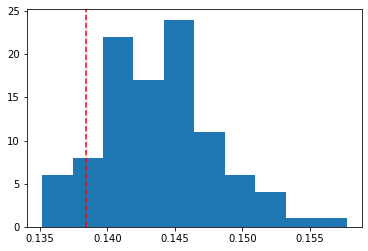

 30%|████████████████████████▉                                                          | 6/20 [04:34<10:39, 45.71s/it]


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [27]:
estimate_power(SIMULATIONS[0], n_jobs=4)

In [11]:
import matplotlib.pyplot as plt
def plot_power2(): 
    
    sim_title = [
        #"Linear", 
        "Independence"
    ]
    sim = multimodal_independence
    power = np.genfromtxt('multimodal_independence_power.csv',
                                      delimiter=',')
    plt.plot(power)
    plt.yticks([0, 1])
    plt.axhline(y=0.05, color='b', linestyle='--')
    positions = (0, 3, 5)
    labels = ("5", "65", "105")
    plt.xticks(positions, labels)
    plt.xlabel("Sample Size")
    plt.ylabel("Mean Power from 20 Reps")
    plt.savefig("C:/Users/siptest/Desktop/NDD/Independence_UF_HonestSampling.jpg", transparent=True, bbox_inches='tight')
    

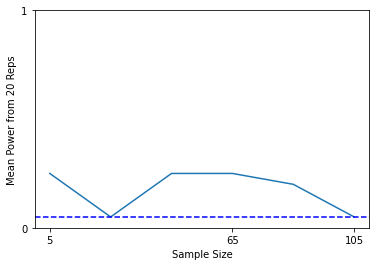

In [12]:
plot_power2()